<h1 align="center">EEG Measurement with Emotiv EEG Neuroheadset</h1>

<p align="center">
    <img src="https://www.simplypsychology.org/wp-content/uploads/Electroencephalography-EEG.jpeg" alt="EEG Measurement" width="400" height="300">
</p>

This document describes the data obtained from a continuous EEG measurement using the Emotiv EEG Neuroheadset. The measurement duration was 117 seconds.

## Eye State Detection

The eye state was detected using a camera during the EEG measurement. The eye state data was added manually to the file after analyzing the video frames. The eye state is represented as follows:
- `2`: Eye-closed
- `1`: Eye-open

## Step 1: Data Overview

In this step, we will expdore the data to understand its structure and gather basic information. This includes loading the data, dispdaying the first few rows, and checking for any missing values or inconsistencies.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
import time
# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
data = pd.read_csv('/kaggle/input/eeg-neuroheadset/eeg-headset.csv')
data["eye_state"] = data["eye_state"].replace({1: 0, 2: 1})
data.head()

,AF3,F7,F3,FC5,T7,P,O1,O2,P8,T8,FC6,F4,F8,AF4,eye_state
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [3]:
features = data.drop(columns = ['eye_state'])
target = data['eye_state']

## Brain Parts and Their Functions

To understand the main parts of the brain that control various functions, refer to the following image:

<p align="center">
    <img src="https://www.researchgate.net/publication/230864997/figure/fig34/AS:341917163376655@1458530812418/Surface-map-of-EEG-electrode-locations.png" alt="Brain Parts and Their Functions" width = "500" height = "350">
</p>

This image provides a detailed overview of each part of the brain and its corresponding functions.

## Step 2: Exploratory Data Analysis (EDA)

In this step, we will perform Exploratory Data Analysis (EDA) to uncover patterns, spot anomalies, and check assumptions with the help of summary statistics and graphical representations. This includes:

- Calculating summary statistics for the dataset.
- Visualizing the correlation matrix to understand relationships between features.
- Identifying features with high correlation.
- Checking for outliers using boxplots.
- Plotting the distribution of each feature.

The goal of EDA is to gain insights into the data and prepare it for further analysis and modeling.

Summary Statistics:
+-------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|       |        AF3         |        F7         |         F3         |        FC5        |        T7         |         P          |        O1         |         O2         |         P8         |        T8         |        FC6        |        F4         |         F8         |        AF4         |     eye_state      |
+-------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
| count |      14980.0    

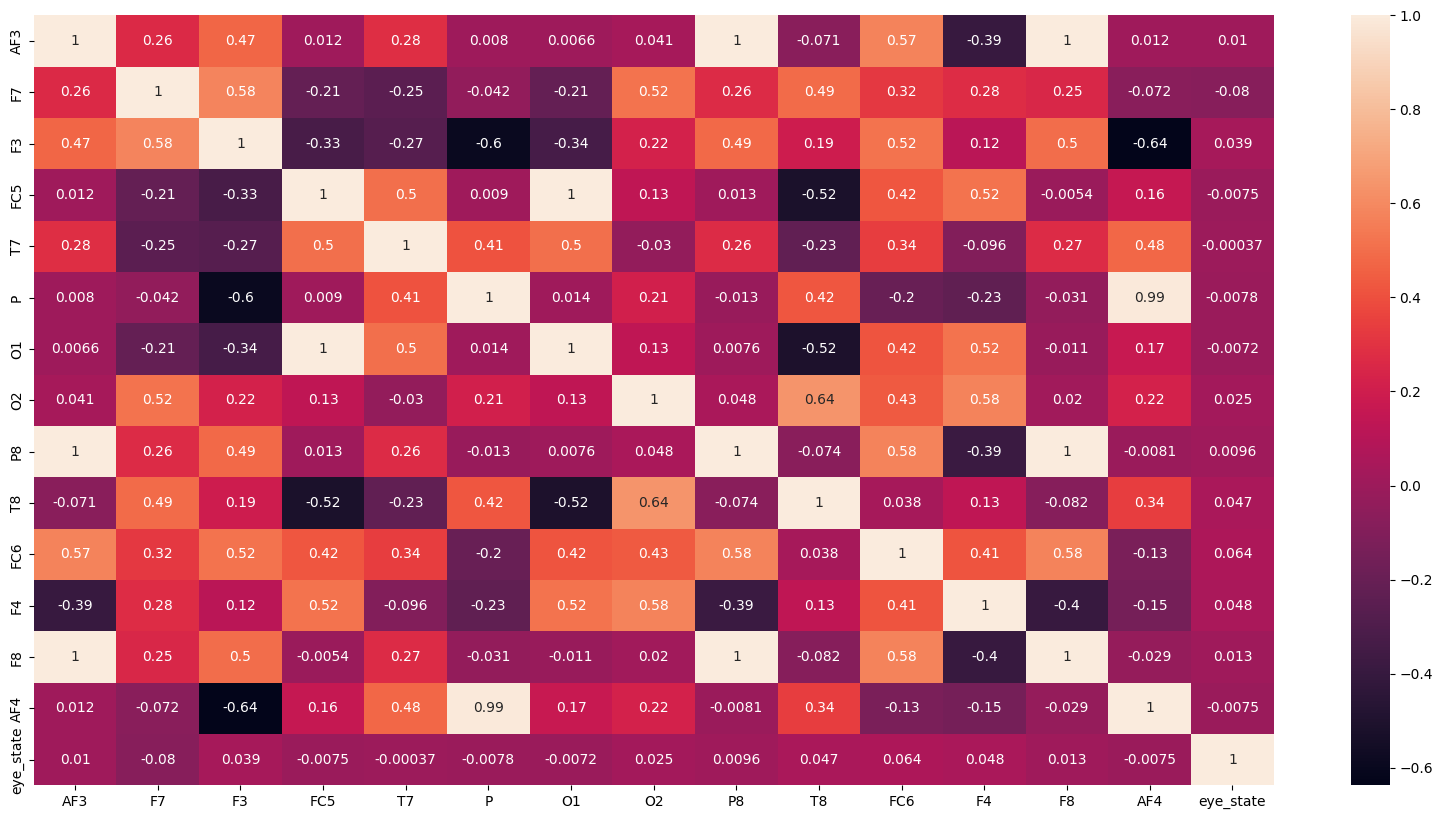

In [4]:
# Calculate summary statistics
summary_stats = data.describe()
# Tabulate summary statistics
print("Summary Statistics:")
print(tabulate(summary_stats, headers='keys', tablefmt='pretty'))

corr_matrix = data.corr()
print("Correlation Matrix:")
ax,fig = plt.subplots(figsize=(20,10))
plot = sns.heatmap(corr_matrix, annot=True, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)

In [5]:
# tell me features that are greater than 0.7 correlation with whom and what is the correlation value
corr_matrix = data.corr()
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            colname = corr_matrix.columns[i]
            correlated_features.add((colname, corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print("Features with correlation greater than 0.7:")
print(tabulate(correlated_features, headers=['Feature 1', 'Feature 2', 'Correlation'], tablefmt='pretty'))

Features with correlation greater than 0.7:
+-----------+-----------+--------------------+
| Feature 1 | Feature 2 |    Correlation     |
+-----------+-----------+--------------------+
|    F8     |    AF3    | 0.9987140947598644 |
|    P8     |    AF3    | 0.9996066187213823 |
|    F8     |    P8     | 0.9988494382235333 |
|    AF4    |     P     | 0.988310438201499  |
|    O1     |    FC5    | 0.9999610708874176 |
+-----------+-----------+--------------------+


**Note:** We can't remove features without proper medical domain knowledge to validate the removal of those cells. It is crucial to consult with a medical expert to ensure the validity and reliability of the data before making any modifications.

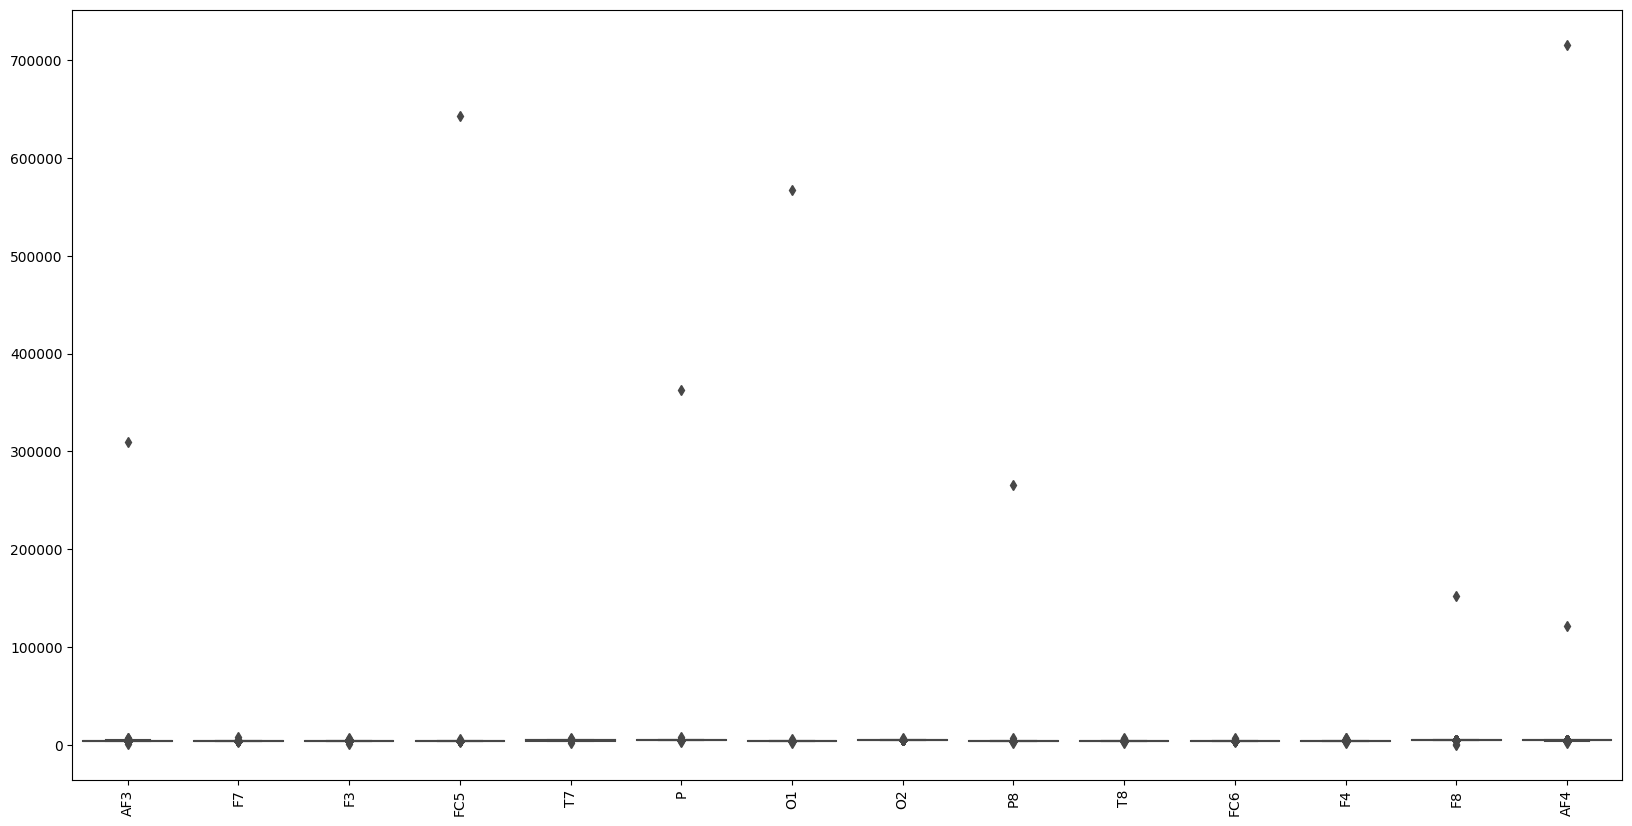

In [6]:
# check outliers in the data using boxplot 
plt.figure(figsize=(20,10))
boxplot = sns.boxplot(data=features)
plt.xticks(rotation=90)
plt.show()

In [7]:
# print rows with outliers greater than 100000 
outliers = data[(data > 100000).any(axis=1)]
print("Rows with outliers greater than 100000:")    
print(tabulate(outliers, headers='keys', tablefmt='pretty'))
# drop them 
data = data[(data < 100000).all(axis=1)]
data.head()

Rows with outliers greater than 100000:
+-------+----------+---------+---------+----------+---------+----------+----------+---------+----------+---------+---------+---------+----------+----------+-----------+
|       |   AF3    |   F7    |   F3    |   FC5    |   T7    |    P     |    O1    |   O2    |    P8    |   T8    |   FC6   |   F4    |    F8    |   AF4    | eye_state |
+-------+----------+---------+---------+----------+---------+----------+----------+---------+----------+---------+---------+---------+----------+----------+-----------+
|  898  | 7222.05  | 3797.95 | 1040.0  | 3733.85  | 6040.51 | 362564.0 | 6350.26  | 5361.54 | 1357.95  | 6215.38 | 3273.33 | 3091.28 |  276.41  | 715897.0 |    0.0    |
| 10386 | 7398.46  | 2830.77 | 2457.44 | 642564.0 | 6474.36 | 8092.31  | 567179.0 | 5087.69 | 7143.59  | 1816.41 | 6137.95 | 6904.62 |  3504.1  | 121026.0 |    0.0    |
| 11509 | 309231.0 | 5500.51 | 6880.51 | 5416.41  | 5454.87 | 4002.05  | 2086.15  | 4770.26 | 265641.0 | 3914.87 | 

,AF3,F7,F3,FC5,T7,P,O1,O2,P8,T8,FC6,F4,F8,AF4,eye_state
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [8]:
data.describe()

,AF3,F7,F3,FC5,T7,P,O1,O2,P8,T8,FC6,F4,F8,AF4,eye_state
count,14977.000000,14977.000000,14977.000000,14977.000000,14977.000000,14977.000000,14977.000000,14977.000000,14977.000000,14977.000000,14977.000000,14977.000000,14977.000000,14977.000000,14977.000000
mean,4301.160232,4009.761022,4264.183621,4122.266256,4341.410935,4619.937029,4072.790210,4615.965342,4201.367435,4231.366095,4202.214729,4279.271757,4605.707913,4361.104574,0.448822
std,46.267900,43.207117,24.598633,24.980265,25.055860,23.913180,21.291349,28.366712,18.115427,28.092878,25.722426,29.983086,49.795111,45.596649,0.497390
min,1030.770000,3905.640000,4197.440000,2453.330000,2089.740000,2768.210000,3581.540000,4567.180000,4147.690000,4152.820000,4100.000000,4201.030000,86.666700,1366.150000,0.000000
25%,4280.510000,3990.770000,4250.260000,4108.210000,4331.790000,4611.790000,4057.950000,4604.620000,4190.770000,4220.510000,4190.260000,4267.690000,4590.770000,4342.050000,0.000000
50%,4294.360000,4005.640000,4262.560000,4120.510000,4338.970000,4617.950000,4070.260000,4613.330000,4199.490000,4229.230000,4200.510000,4276.920000,4603.080000,4354.870000,0.000000
75%,4311.790000,4023.080000,4270.770000,4132.310000,4347.180000,4626.670000,4083.590000,4624.100000,4209.230000,4239.490000,4211.280000,4287.180000,4617.440000,4372.820000,1.000000
max,4504.100000,7804.620000,5762.560000,4250.260000,4463.590000,4756.920000,4178.460000,7264.100000,4586.150000,6674.360000,5170.770000,7002.560000,4833.850000,4573.330000,1.000000


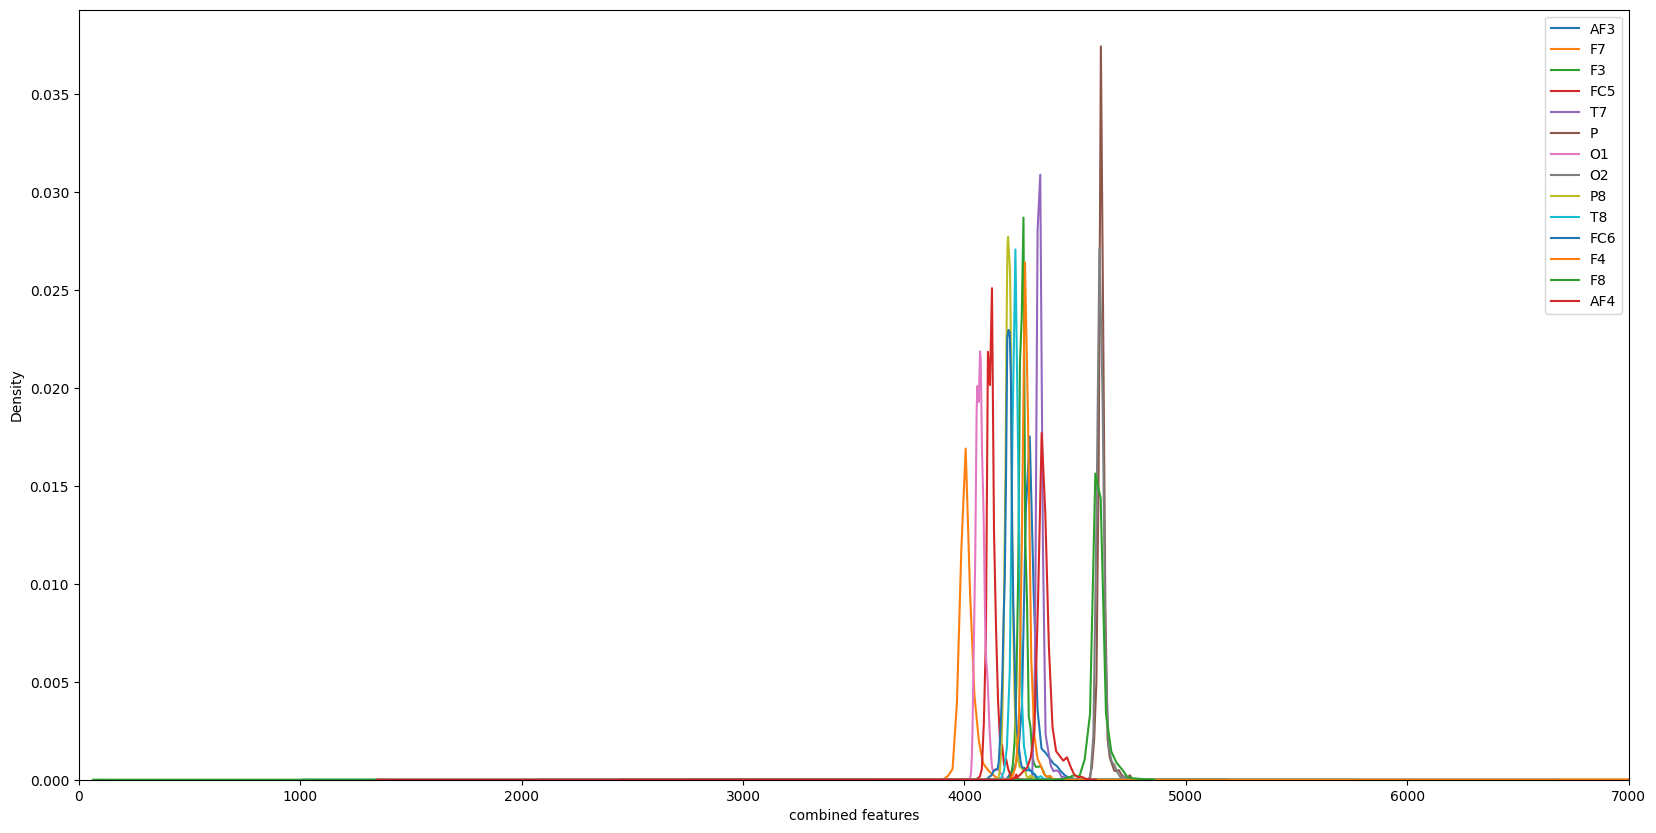

In [9]:
# plot distribution of each feature combined in one plot
plt.figure(figsize=(20,10))
for column in features.columns:
    sns.kdeplot(data[column], label=column)
plt.xlim(0, 7000)
plt.xlabel('combined features')
plt.ylabel('Density')
plt.legend()
plt.show()

# Machine Learning Model Evaluation Pipeline

This pipeline covers the entire process of training, tuning, evaluating, and saving machine learning models on a dataset. The process is broken down into several key stages:

## 1. **Data Loading and Preprocessing**
   - The first step is to load the dataset and separate it into features (`X`) and target variable (`y`).
   - The data is split into three parts: 
     - **Training Set (80%)**: Used to train models.
     - **Validation Set (20%)**: Used for model tuning and selection.
     - **Test Set (20%)**: Used to evaluate the final model's performance.
   - The features are scaled using `StandardScaler` to ensure the models work effectively, especially for models sensitive to feature scales like SVM or KNN.


In [10]:
# Data Loading and Preprocessing
def load_and_preprocess_data(df):
    """Load and preprocess the data"""
    
    # Separate features and target
    X = df.drop('eye_state', axis=1)
    y = df['eye_state']
    
    # Split data into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42,shuffle=True)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

## 2. **Model Definition and Hyperparameter Search**
   - Multiple machine learning models are defined, including:
     - **Random Forest**  
     - **Extra Trees**  
     - **AdaBoost**  
     - **Gradient Boosting**  
     - **Support Vector Classifier (SVC)**  
     - **K-Nearest Neighbors (KNN)**  
     - **Decision Tree**  
     - **MLP Classifier**
   - For each model, a set of hyperparameters is defined for tuning using `RandomizedSearchCV`.
   - Randomized search performs a random search over hyperparameters, testing different combinations to identify the best-performing configuration.


In [11]:
models_params = {
    "Extra Trees": (ExtraTreesClassifier(), {
        "n_estimators": [100, 200, 300, 500],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2", None],
        "bootstrap": [True, False]
    }),
    "AdaBoost": (AdaBoostClassifier(), {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.5, 1.0],
        "algorithm": ['SAMME', 'SAMME.R']
    }),
    "Gradient Boosting": (GradientBoostingClassifier(), {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.3],
        "max_depth": [3, 5, 7],
        "min_samples_split": [2, 5, 10],
        "subsample": [0.8, 0.9, 1.0]
    }),
    "Random Forest": (RandomForestClassifier(), {
        "n_estimators": [100, 200, 500],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2", None],
        "bootstrap": [True, False]
    }),
    "Support Vector Classifier": (SVC(), {
        "C": [0.1, 1, 10],
        "kernel": ['linear', 'rbf'],
        "gamma": ['scale', 'auto']
    }),
    "K-Nearest Neighbors": (KNeighborsClassifier(), {
        "n_neighbors": [3, 5, 7, 10],
        "weights": ['uniform', 'distance'],
        "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']
    }),
    "Decision Tree": (DecisionTreeClassifier(), {
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "criterion": ['gini', 'entropy']
    }),
    "MLP Classifier": (MLPClassifier(), {
        "hidden_layer_sizes": [(50,), (100,), (50, 50)],
        "activation": ['relu', 'tanh', 'logistic'],
        "solver": ['adam', 'sgd'],
        "max_iter": [200, 300]
    }),
    "XGBoost": (xgb.XGBClassifier(), {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.3],
        "max_depth": [3, 5, 7],
        "subsample": [0.8, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.8, 0.9]
    }),
    "LightGBM": (lgb.LGBMClassifier(), {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.3],
        "max_depth": [3, 5, 7],
        "num_leaves": [31, 50, 100],
        "subsample": [0.8, 0.9, 1.0]
    })
}


## 3. **Model Training and Evaluation**
   - Each model is trained on the training data (`X_train`, `y_train`) with its hyperparameters optimized.
   - Once the best hyperparameters for each model are found, the models are evaluated on the **validation set** (`X_val`, `y_val`).
   - The following evaluation metrics are computed for each model:
     - **Accuracy**
     - **Precision**
     - **Recall**
     - **F1 Score**

In [12]:
# Model Evaluation Metrics
def evaluate_metrics(y_true, y_pred):
    """Calculate multiple classification metrics"""
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1 Score': f1_score(y_true, y_pred, average='weighted')
    }
    return metrics

   - A confusion matrix is plotted for each model to visualize the model's performance in terms of true positives, false positives, true negatives, and false negatives.
   - The model that performs the best based on the **F1 score** is selected.

In [13]:
def plot_confusion_matrix(y_true, y_pred, title):
    """Plot confusion matrix using seaborn"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    
    # Replace 0 with 'open' and 1 with 'closed'
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['open', 'closed'], yticklabels=['open', 'closed'])
    
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [14]:
# Model Tuning and Evaluation
def tune_and_evaluate(X_train, X_val, y_train, y_val):
    """Tune models and evaluate on validation set"""
    best_models = {}
    all_metrics = {}
    
    for name, (model, params) in models_params.items():
        print(f"\nTuning {name}...")
        search = RandomizedSearchCV(
            model, params, n_iter=10, cv=3, 
            scoring="accuracy", n_jobs=-1, 
            verbose=1, random_state=42
        )
        search.fit(X_train, y_train)
        
        best_models[name] = search.best_estimator_
        y_val_pred = search.best_estimator_.predict(X_val)
        metrics = evaluate_metrics(y_val, y_val_pred)
        all_metrics[name] = metrics
        
        print(f"\nBest parameters for {name}:")
        print(search.best_params_)
        print("\nValidation Metrics:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
        
        # Plot confusion matrix
        plot_confusion_matrix(y_val, y_val_pred, name)
    
    # Model Comparison Table
    metrics_df = pd.DataFrame(all_metrics).T
    print("\nModel Comparison:")
    print(tabulate(metrics_df, headers='keys', tablefmt='pipe', floatfmt='.4f'))
    
    # Select best model based on F1 score
    best_model_name = max(all_metrics, key=lambda x: all_metrics[x]['F1 Score'])
    best_model = best_models[best_model_name]
    
    print(f"\nBest Model: {best_model_name}")
    print("Validation Metrics for Best Model:")
    for metric, value in all_metrics[best_model_name].items():
        print(f"{metric}: {value:.4f}")
    
    return best_model_name, best_model

## 4. **Model Selection and Testing**
   - After identifying the best model from the validation set, the chosen model is evaluated on the **test set** (`X_test`, `y_test`) to assess its generalization ability on unseen data.
   - The same evaluation metrics are computed on the test set, and the confusion matrix is plotted for the final model's performance.

In [15]:
# Test Evaluation
def evaluate_on_test(best_model, best_model_name, X_test, y_test):
    """Evaluate best model on test set"""
    y_pred = best_model.predict(X_test)
    test_metrics = evaluate_metrics(y_test, y_pred)
    
    print("\nTest Set Evaluation:")
    print(f"Model: {best_model_name}")
    for metric_name, value in test_metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, f"{best_model_name} (Test Set)")
    
    return test_metrics

## 5. **Model Comparison**
   - A comparison table of all the models is printed, showing how each performed on the validation set.
   - The table includes the F1 score, accuracy, precision, and recall for each model, helping to choose the best one based on your needs.


Loading and preprocessing data...

Tuning models and evaluating on validation set...

Tuning Extra Trees...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for Extra Trees:
{'n_estimators': 200, 'min_samples_split': 2, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}

Validation Metrics:
Accuracy: 0.9499
Precision: 0.9504
Recall: 0.9499
F1 Score: 0.9498


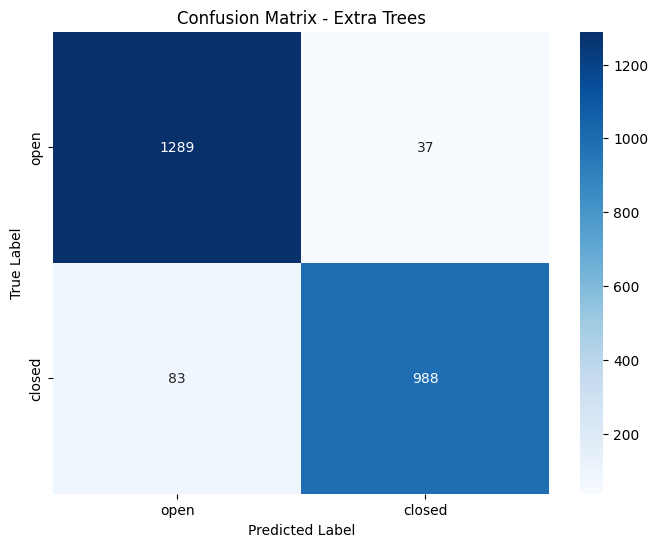


Tuning AdaBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for AdaBoost:
{'n_estimators': 50, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}

Validation Metrics:
Accuracy: 0.7409
Precision: 0.7402
Recall: 0.7409
F1 Score: 0.7402


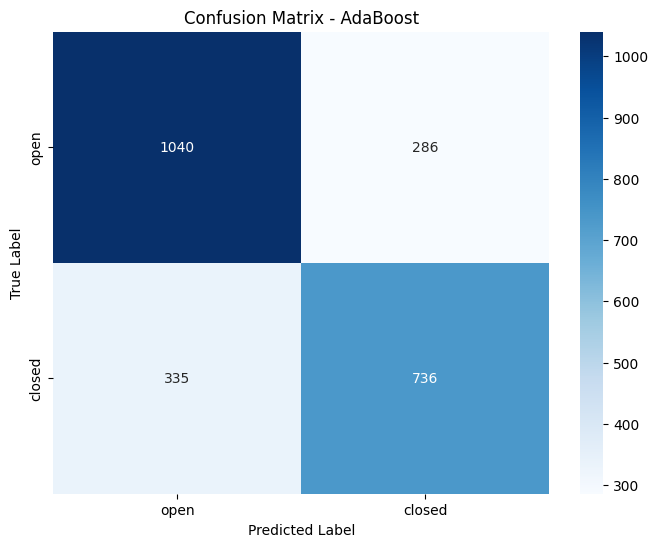


Tuning Gradient Boosting...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for Gradient Boosting:
{'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 5, 'max_depth': 7, 'learning_rate': 0.1}

Validation Metrics:
Accuracy: 0.9424
Precision: 0.9426
Recall: 0.9424
F1 Score: 0.9423


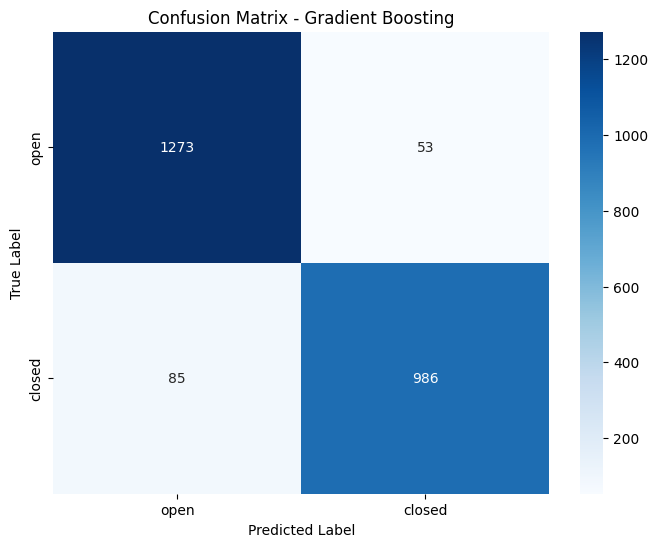


Tuning Random Forest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for Random Forest:
{'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

Validation Metrics:
Accuracy: 0.9332
Precision: 0.9334
Recall: 0.9332
F1 Score: 0.9331


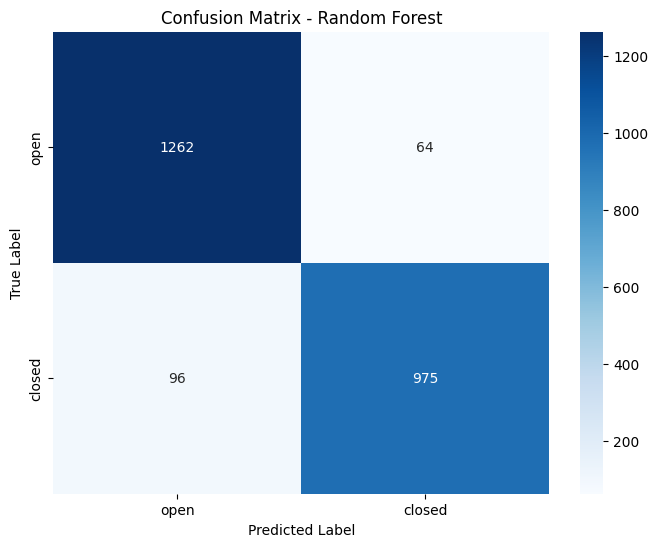


Tuning Support Vector Classifier...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for Support Vector Classifier:
{'kernel': 'rbf', 'gamma': 'auto', 'C': 10}

Validation Metrics:
Accuracy: 0.9320
Precision: 0.9320
Recall: 0.9320
F1 Score: 0.9319


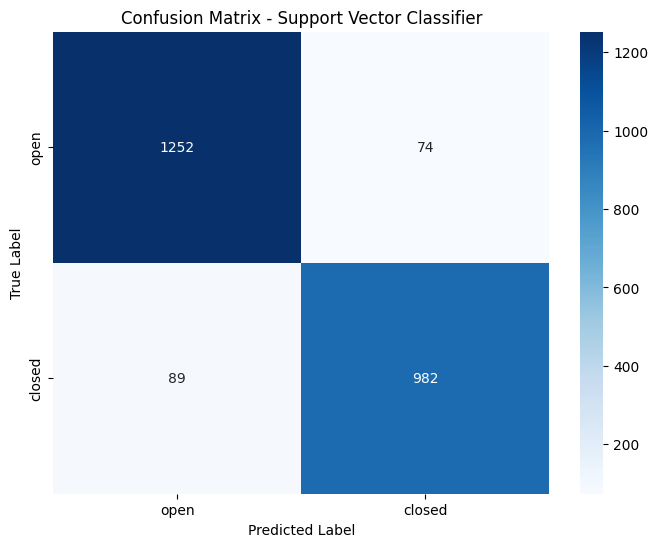


Tuning K-Nearest Neighbors...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for K-Nearest Neighbors:
{'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'kd_tree'}

Validation Metrics:
Accuracy: 0.9579
Precision: 0.9579
Recall: 0.9579
F1 Score: 0.9579


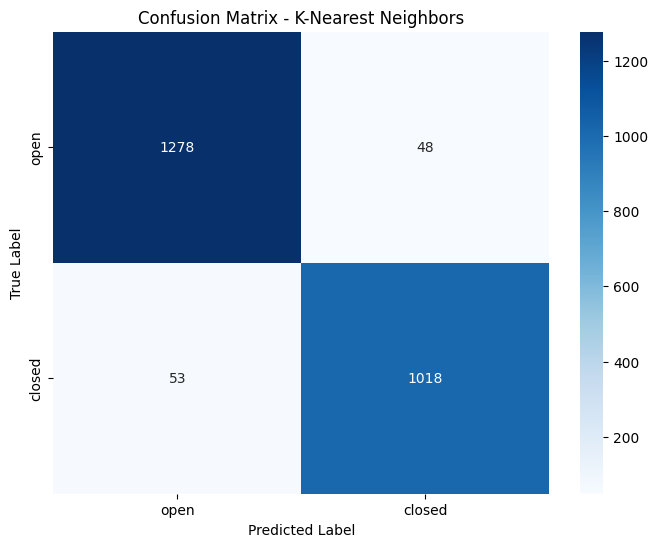


Tuning Decision Tree...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for Decision Tree:
{'min_samples_split': 2, 'max_depth': 20, 'criterion': 'entropy'}

Validation Metrics:
Accuracy: 0.8436
Precision: 0.8438
Recall: 0.8436
F1 Score: 0.8437


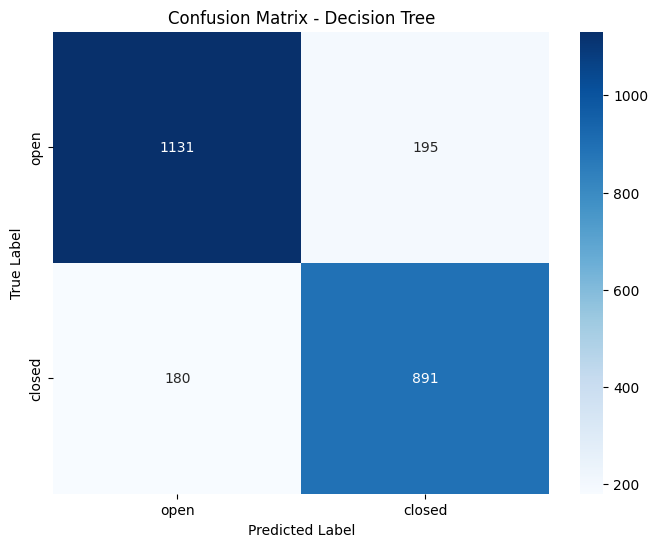


Tuning MLP Classifier...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for MLP Classifier:
{'solver': 'adam', 'max_iter': 200, 'hidden_layer_sizes': (50, 50), 'activation': 'relu'}

Validation Metrics:
Accuracy: 0.9533
Precision: 0.9533
Recall: 0.9533
F1 Score: 0.9533


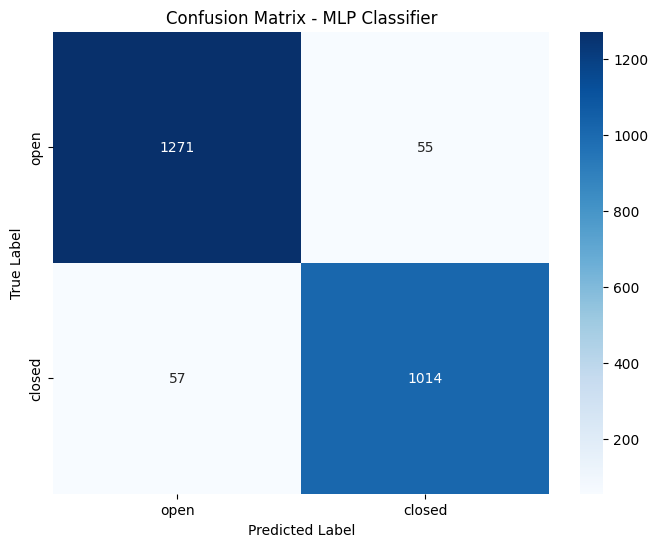


Tuning XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters for XGBoost:
{'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8}

Validation Metrics:
Accuracy: 0.9320
Precision: 0.9320
Recall: 0.9320
F1 Score: 0.9319


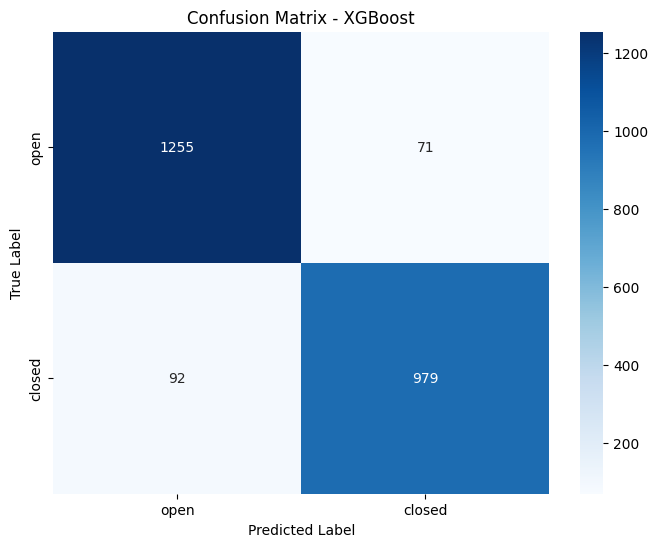


Tuning LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 4290, number of negative: 5294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3509
[LightGBM] [Info] Number of data points in the train set: 9584, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447621 -> initscore=-0.210287
[LightGBM] [Info] Start training from score -0.210287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

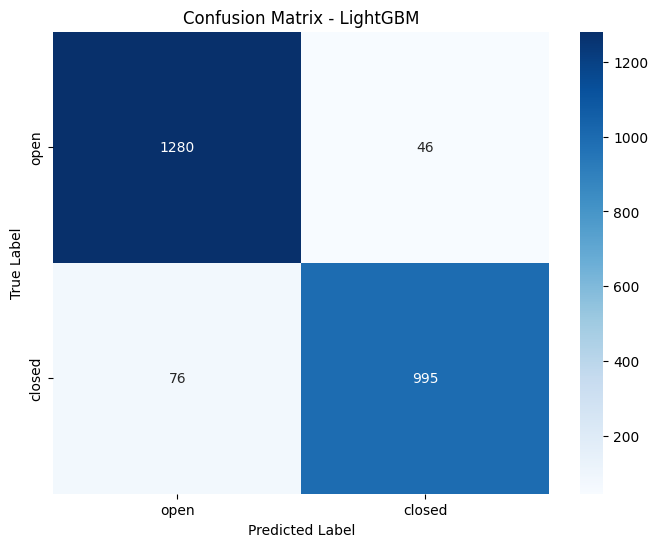


Model Comparison:
|                           |   Accuracy |   Precision |   Recall |   F1 Score |
|:--------------------------|-----------:|------------:|---------:|-----------:|
| Extra Trees               |     0.9499 |      0.9504 |   0.9499 |     0.9498 |
| AdaBoost                  |     0.7409 |      0.7402 |   0.7409 |     0.7402 |
| Gradient Boosting         |     0.9424 |      0.9426 |   0.9424 |     0.9423 |
| Random Forest             |     0.9332 |      0.9334 |   0.9332 |     0.9331 |
| Support Vector Classifier |     0.9320 |      0.9320 |   0.9320 |     0.9319 |
| K-Nearest Neighbors       |     0.9579 |      0.9579 |   0.9579 |     0.9579 |
| Decision Tree             |     0.8436 |      0.8438 |   0.8436 |     0.8437 |
| MLP Classifier            |     0.9533 |      0.9533 |   0.9533 |     0.9533 |
| XGBoost                   |     0.9320 |      0.9320 |   0.9320 |     0.9319 |
| LightGBM                  |     0.9491 |      0.9493 |   0.9491 |     0.9490 |

Best Mod

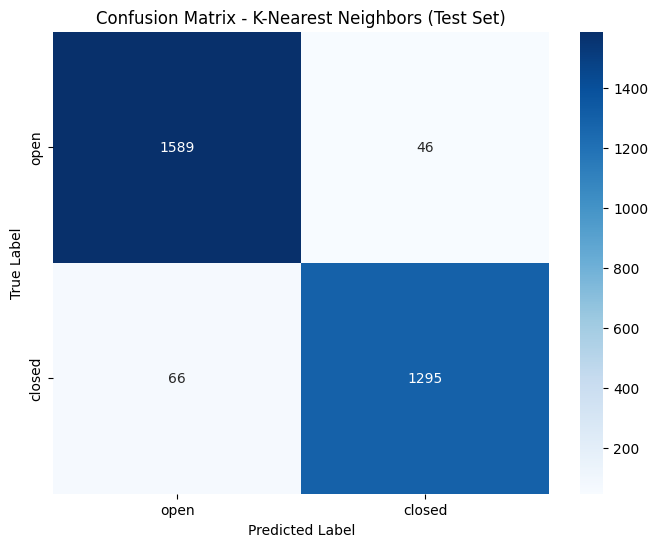

In [16]:
print("Loading and preprocessing data...")
X_train, X_val, X_test, y_train, y_val, y_test = load_and_preprocess_data(df=data)

# Tune models and find the best one
print("\nTuning models and evaluating on validation set...")
best_model_name, best_model = tune_and_evaluate(X_train, X_val, y_train, y_val)

# Evaluate best model on test set
print("\nEvaluating best model on test set...")
test_metrics = evaluate_on_test(best_model, best_model_name, X_test, y_test)

# Making Random Generation Simulation!

In [17]:
# Feature and target separation
feature_columns = data.columns[:-1]  # Exclude 'eye_state'
target_column = "eye_state"

X_data = data[feature_columns].values  # Extract feature matrix
y_data = data[target_column].values  # Extract actual labels

# Function to map 0 → "Open" and 1 → "Closed"
def eye_state_label(state):
    return "Open" if state == 0 else "Closed"

# Initialize the scaler and fit it on the training data
scaler = StandardScaler()
scaler.fit(X_data)

# Simulate 5 random samples
for _ in range(5):
    # Select a random row index from the dataset
    random_index = np.random.randint(0, X_data.shape[0])

    # Get the corresponding sample and actual value
    random_sample = X_data[random_index]
    real_eye_state = eye_state_label(y_data[random_index])  # Convert to "Open"/"Closed"

    # Scale the random sample
    random_sample_scaled = scaler.transform(random_sample.reshape(1, -1))

    # Predict eye state
    predicted_eye_state = eye_state_label(best_model.predict(random_sample_scaled.reshape(1, -1))[0])

    # Display real vs. predicted values
    print(f"Random EEG Sample Index: {random_index}")
    print(f"Feature Values: {random_sample}")
    print(f"Actual Eye State   : {real_eye_state}")
    print(f"Predicted Eye State: {predicted_eye_state}")
    print("-" * 50)

Random EEG Sample Index: 1829
Feature Values: [4285.64 4004.62 4264.1  4115.38 4320.   4615.9  4071.79 4608.72 4201.03
 4224.62 4162.56 4271.79 4584.1  4352.31]
Actual Eye State   : Open
Predicted Eye State: Open
--------------------------------------------------
Random EEG Sample Index: 13977
Feature Values: [4280.   4034.87 4255.9  4123.59 4337.44 4620.51 4065.64 4596.41 4182.56
 4206.15 4174.87 4253.33 4596.41 4327.69]
Actual Eye State   : Open
Predicted Eye State: Open
--------------------------------------------------
Random EEG Sample Index: 6606
Feature Values: [4282.05 3989.23 4248.21 4105.13 4320.   4609.23 4047.18 4612.82 4192.31
 4225.13 4185.13 4277.44 4590.77 4348.72]
Actual Eye State   : Open
Predicted Eye State: Open
--------------------------------------------------
Random EEG Sample Index: 13401
Feature Values: [4271.28 3997.44 4249.23 4122.05 4336.92 4604.62 4056.41 4601.03 4194.87
 4220.   4195.38 4266.15 4585.64 4341.03]
Actual Eye State   : Open
Predicted Eye State